In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime
import xlrd

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
%cd drive/MyDrive/Skripsi Abdul Hakim/piton skripsi

Mounted at /content/drive
/content/drive/MyDrive/Skripsi Abdul Hakim/piton skripsi


Model prediksi TMA terbaik terdapat pada stasiun Muara Medak 2 dengan
epoch 50, LSTM layer 50, dropout 0,2, dense 300, LSTM layer 10, dropout 0,4,
menghasilkan Korelasi sebesar 0,994, RMSE 0,008, MAE 0,006 dan MAPE 0,009.
Model terbaik yang didapatkan sudah dapat digunakan untuk memprediksi TMA pada
dataset sensor yang tidak dilatih untuk pemodelan.

cobain boxplot
bandingan dengan fbprophet

minmax scaler negative

Gridsearch
randomsearch
bayesiansearch
metode cari optimal hyperparameter

# Read data

In [ ]:
dataset = pd.read_pickle("impute/Cinta Jaya 1_knn.pkl")
dataset

,rain,soil,gwl,temp
date,,,,
2018-11-10 11:40:00,0.4,3.2,-1.1266,30.7
2018-11-10 11:50:00,0.0,3.2,-1.1266,30.7
2018-11-10 12:00:00,0.0,3.2,-1.1266,30.7
2018-11-10 12:10:00,0.0,3.2,-1.1100,31.1
2018-11-10 12:20:00,0.0,3.2,-1.1100,31.1
...,...,...,...,...
2020-01-10 02:00:00,0.0,29.0,-0.8760,29.5
2020-01-10 02:10:00,0.0,29.0,-0.8860,29.5
2020-01-10 02:20:00,0.0,29.0,-0.8810,29.5


# LSTM (Multivariate)

In [ ]:
# prepare data for lstm
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import LSTM

## Convert to Supervised Learning

In [ ]:
# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = DataFrame(data)
    cols, names = list(), list()
    
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
    if i == 0:
        names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
    else:
        names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    
    # put it all together
    agg = concat(cols, axis=1)
    agg.columns = names
    
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [ ]:
values = dataset.values

## Normalization

In [ ]:
scaler = MinMaxScaler(feature_range=(-1,1))
scaled = scaler.fit_transform(values)
scaled

array([[-0.99544937, -0.93081081, -0.91413333,  0.79532164],
       [-1.        , -0.93081081, -0.91413333,  0.79532164],
       [-1.        , -0.93081081, -0.91413333,  0.79532164],
       ...,
       [-1.        , -0.37297297, -0.58666667,  0.7251462 ],
       [-1.        , -0.38162162, -0.58266667,  0.7251462 ],
       [-1.        , -0.37297297, -0.58      ,  0.7251462 ]])

In [ ]:
reframed = series_to_supervised(scaled, 1, 1)
reframed

,var1(t-1),var2(t-1),var3(t-1),var4(t-1),var1(t),var2(t),var3(t),var4(t)
1,-0.995449,-0.930811,-0.914133,0.795322,-1.0,-0.930811,-0.914133,0.795322
2,-1.000000,-0.930811,-0.914133,0.795322,-1.0,-0.930811,-0.914133,0.795322
3,-1.000000,-0.930811,-0.914133,0.795322,-1.0,-0.930811,-0.892000,0.818713
4,-1.000000,-0.930811,-0.892000,0.818713,-1.0,-0.930811,-0.892000,0.818713
5,-1.000000,-0.930811,-0.892000,0.818713,-1.0,-0.930811,-0.892000,0.818713
...,...,...,...,...,...,...,...,...
53319,-1.000000,-0.372973,-0.582667,0.725146,-1.0,-0.372973,-0.580000,0.725146
53320,-1.000000,-0.372973,-0.580000,0.725146,-1.0,-0.372973,-0.593333,0.725146
53321,-1.000000,-0.372973,-0.593333,0.725146,-1.0,-0.372973,-0.586667,0.725146
53322,-1.000000,-0.372973,-0.586667,0.725146,-1.0,-0.381622,-0.582667,0.725146


## Train and Test Split

In [ ]:
n_train = round(53323 * 0.8)

values = reframed.values

In [ ]:
train = values[:n_train, :]
test  = values[n_train:, :]

In [ ]:
train

array([[-0.99544937, -0.93081081, -0.91413333, ..., -0.93081081,
        -0.91413333,  0.79532164],
       [-1.        , -0.93081081, -0.91413333, ..., -0.93081081,
        -0.91413333,  0.79532164],
       [-1.        , -0.93081081, -0.91413333, ..., -0.93081081,
        -0.892     ,  0.81871345],
       ...,
       [-1.        , -0.92      , -0.92533333, ..., -0.93297297,
        -0.92533333,  0.83625731],
       [-1.        , -0.93297297, -0.92533333, ..., -0.92      ,
        -0.932     ,  0.87719298],
       [-1.        , -0.92      , -0.932     , ..., -0.92      ,
        -0.92533333,  0.87719298]])

In [ ]:
test

array([[-1.        , -0.92      , -0.92533333, ..., -0.92      ,
        -0.92533333,  0.89473684],
       [-1.        , -0.92      , -0.92533333, ..., -0.92      ,
        -0.92533333,  0.89473684],
       [-1.        , -0.92      , -0.92533333, ..., -0.92      ,
        -0.928     ,  0.89473684],
       ...,
       [-1.        , -0.37297297, -0.59333333, ..., -0.37297297,
        -0.58666667,  0.7251462 ],
       [-1.        , -0.37297297, -0.58666667, ..., -0.38162162,
        -0.58266667,  0.7251462 ],
       [-1.        , -0.38162162, -0.58266667, ..., -0.37297297,
        -0.58      ,  0.7251462 ]])

In [ ]:
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]

In [ ]:
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(42658, 1, 7) (42658,) (10665, 1, 7) (10665,)


## LSTM Architecture

**LSTM Architecture**

Layer  
1 input layer (4 node)  
2 LSTM layer  
2 dropout layer  
2 dense layer  
1 output layer  

Activation Function
tanh, sigmoid, relu

Optimizer
Adam

In [ ]:
#epoch = [25, 50]
#unit_1 = [10, 30, 50]
#dropout_1 = [0.2, 0.4, 0.6]
#unit_2 = [10, 30, 50]
#dropout_2 = [0.2, 0.4, 0.6]
#dense = [100, 300, 500]

In [ ]:
# model = Sequential([
#     LSTM(10, input_shape=(train_X.shape[1], train_X.shape[2])),
#     Dropout(0.2),
#     Dense(0.1, activation='relu'),
    
#     LSTM(10, return_sequences=False),
#     Dropout(0.2),
#     Dense(1),
# ])

# model.compile(loss='mae', optimizer='adam')

In [ ]:
model = Sequential()
model.add(LSTM(10, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dropout(0.2))
model.add(Dense(0.1, activation='relu'))
    
# model.add(LSTM(10, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(1))


model.compile(loss='mae', optimizer='adam')

In [ ]:
paramaters = {
    'epoch' = [10, 50, 100],
    
}

In [ ]:
# fit network
history = model.fit(train_X, train_y, epochs=20, batch_size=72, validation_data=(test_X, test_y), verbose=2, shuffle=False)

Epoch 1/20
593/593 - 6s - loss: 0.7842 - val_loss: 0.8575 - 6s/epoch - 11ms/step
Epoch 2/20
593/593 - 2s - loss: 0.7842 - val_loss: 0.8575 - 2s/epoch - 3ms/step
Epoch 3/20
593/593 - 2s - loss: 0.7842 - val_loss: 0.8575 - 2s/epoch - 3ms/step
Epoch 4/20
593/593 - 2s - loss: 0.7842 - val_loss: 0.8575 - 2s/epoch - 3ms/step
Epoch 5/20
593/593 - 2s - loss: 0.7842 - val_loss: 0.8575 - 2s/epoch - 3ms/step
Epoch 6/20
593/593 - 2s - loss: 0.7842 - val_loss: 0.8575 - 2s/epoch - 3ms/step
Epoch 7/20
593/593 - 2s - loss: 0.7842 - val_loss: 0.8575 - 2s/epoch - 4ms/step
Epoch 8/20
593/593 - 2s - loss: 0.7842 - val_loss: 0.8575 - 2s/epoch - 4ms/step
Epoch 9/20
593/593 - 2s - loss: 0.7842 - val_loss: 0.8575 - 2s/epoch - 3ms/step
Epoch 10/20
593/593 - 2s - loss: 0.7842 - val_loss: 0.8575 - 2s/epoch - 3ms/step
Epoch 11/20
593/593 - 2s - loss: 0.7842 - val_loss: 0.8575 - 2s/epoch - 3ms/step
Epoch 12/20
593/593 - 2s - loss: 0.7842 - val_loss: 0.8575 - 2s/epoch - 3ms/step
Epoch 13/20
593/593 - 2s - loss: 0.7

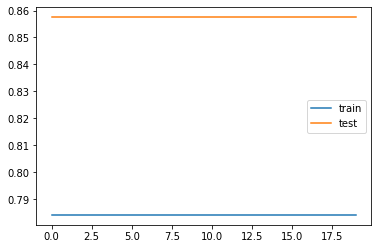

In [ ]:
from matplotlib import pyplot
# plot history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

In [ ]:
from math import sqrt
from numpy import concatenate

# make a prediction
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))

334/334 [==============================] - 1s 2ms/step


In [ ]:
# invert scaling for forecast
inv_yhat = concatenate((yhat, test_X[:, 1:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]

# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = concatenate((test_y, test_X[:, 1:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]

ValueError: ignored

In [ ]:
# calculate RMSE
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

# Reference
1. https://machinelearningmastery.com/how-to-develop-lstm-models-for-time-series-forecasting/
2. https://machinelearningmastery.com/grid-search-hyperparameters-deep-learning-models-python-keras/
3. https://medium.com/hackernoon/understanding-architecture-of-lstm-cell-from-scratch-with-code-8da40f0b71f4